In [92]:
%load_ext autoreload
%autoreload 2
import seml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from poisson_atac.utils import model_type_map

In [118]:
seml_collection = "atac_to_atac"

def load_seml(seml_database, model_type_map):
    dataset_map = {'neurips': 'Neurips\nall batches', 'hematopoiesis': 'Satpathy\net al.'}
    results = seml.get_results(seml_database, to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"],)
    print(results['config.model.model_type'].unique())
    results['config.data.dataset'] = results['config.data.dataset'].map(dataset_map)
    
    results['config.setup.model_params.use_observed_lib_size'] = results['config.setup.model_params.use_observed_lib_size'].map({True: "True", False:"False", np.nan: ''})
    results['config.model.model_type'] = results['config.model.model_type'] + results['config.setup.model_params.use_observed_lib_size'].astype(str) 
    print(results['config.model.model_type'].unique())
    results["config.model.model_type"] = results["config.model.model_type"].map(model_type_map)

    results.loc[:, ["result.poisson_loss", "result.r2_score"]] = np.nan
    results.loc[~results['result.test_cells_counts'].isna(), ["result.poisson_loss", "result.r2_score"]] = pd.concat(results['result.test_cells_counts'].values, axis =1).T.dropna(axis=1, how='all').values
    return results

In [122]:
results = load_seml(seml_collection, model_type_map)
results = results[~results['config.data.batch'].isna()]
results.loc[results["config.model.model_type"].isna(), "config.model.model_type"] = 'Binary VAE (obs. ls)'

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

['poissonvi' 'peakvi' 'binaryvi']
['poissonviFalse' 'poissonviTrue' 'peakvi' 'binaryvi' 'binaryviTrue'
 'binaryviFalse']


In [105]:

#model_order = [model_type_map['poissonvi'], model_type_map['binaryvi'], model_type_map["peakvi"]]

#model_order

In [ ]:
results['config.data.dataset'].values

array(['Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Neurips\nall batches', 'Neurips\nall batches',
       'Ne

In [188]:
dfs = []
for dataset in results['config.data.dataset'].unique():
    print(dataset)
    scib_table = pd.concat(results.loc[results['config.data.dataset'] == dataset, 'result.embedding'].values, axis =1).T

    batch_metrics = ['PCR_batch', 'ASW_label/batch', 'iLISI', 'graph_conn']
    bio_metrics = ['NMI_cluster/label', 'ARI_cluster/label', 'ASW_label', 'isolated_label_F1', 'isolated_label_silhouette', 'cLISI','trajectory']

    scib_table = scib_table.loc[:, batch_metrics+bio_metrics]

    #min_max_scaling
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    scib_table = pd.DataFrame(scaler.fit_transform(scib_table), columns=scib_table.columns)
    weight_batch=0.4

    score_group_batch = scib_table.loc[:, batch_metrics].mean(axis=1)
    score_group_bio = scib_table.loc[:, bio_metrics].mean(axis=1)
    score_all = (weight_batch*score_group_batch + (1-weight_batch)*score_group_bio)

    scib_table.insert(0, "Overall", score_all)
    dfs.append(scib_table)

Neurips
all batches
Satpathy
et al.


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [190]:
scib_table = pd.concat(dfs)

In [191]:
scib_table["Model"] = results['config.model.model_type'].values
scib_table["Dataset"] = results['config.data.dataset'].values
scib_table["n_latent"] = results['config.setup.model_params.n_latent'].values
scib_table["model_hash"] = results['config_hash'].values

Neurips
all batches
Satpathy
et al.


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


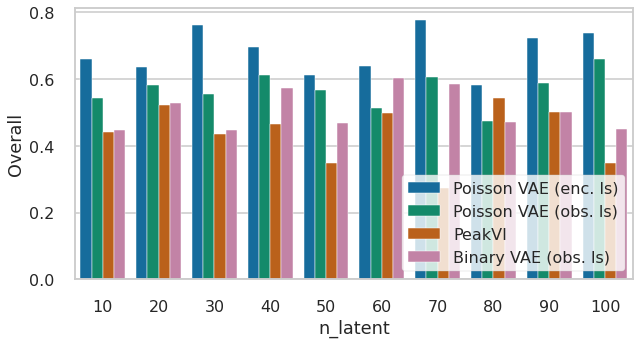

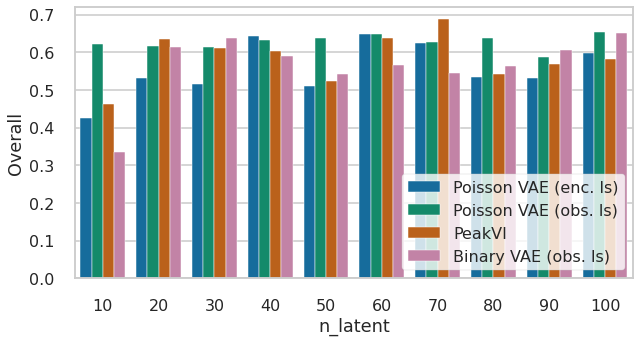

In [195]:
for dataset in scib_table['Dataset'].unique():
    print(dataset)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(data=scib_table[scib_table['Dataset'] == dataset], x="n_latent", y="Overall", hue="Model", ax=ax)
    plt.legend(loc="lower right")

<AxesSubplot:xlabel='config.setup.model_params.n_latent', ylabel='result.average_precision'>

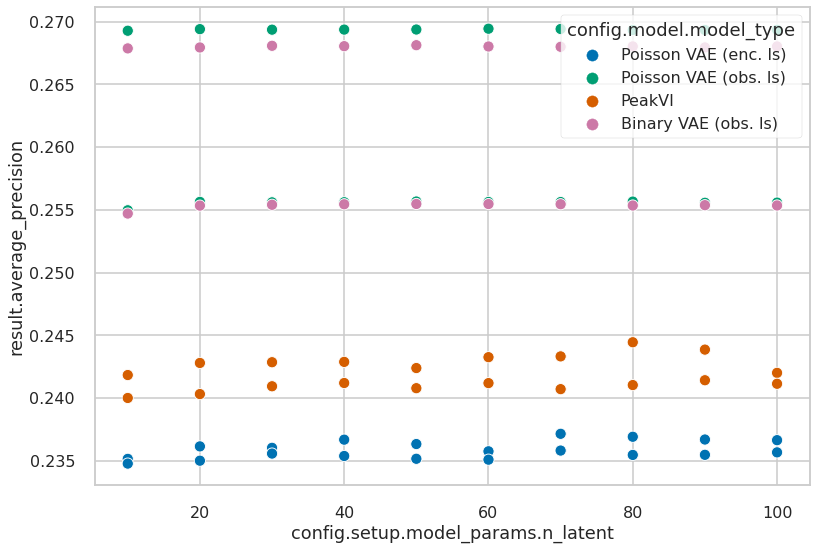

In [196]:
# Reconstruction metrics

sns.scatterplot(data=results, x="config.setup.model_params.n_latent", y="result.average_precision", hue="config.model.model_type")

<AxesSubplot:xlabel='config.setup.model_params.n_latent', ylabel='result.rmse'>

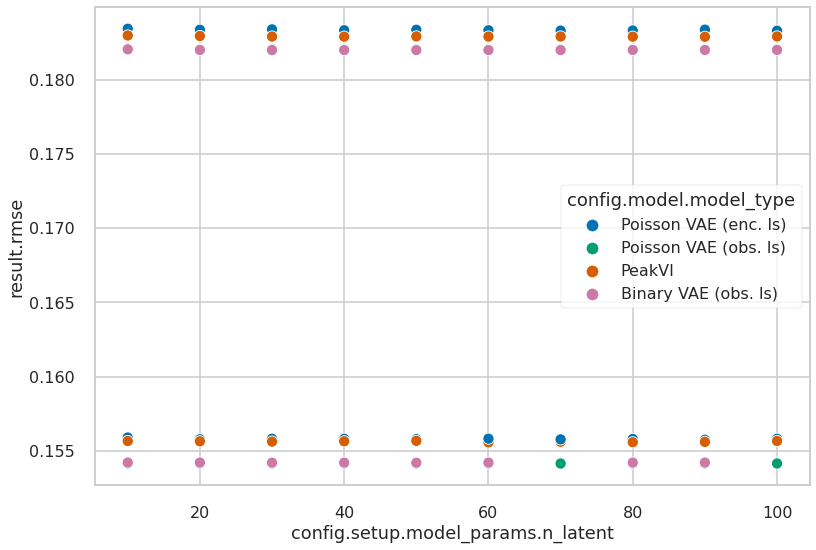

In [197]:
sns.scatterplot(data=results, x="config.setup.model_params.n_latent", y="result.rmse", hue="config.model.model_type")

<AxesSubplot:xlabel='config.setup.model_params.n_latent', ylabel='result.bce'>

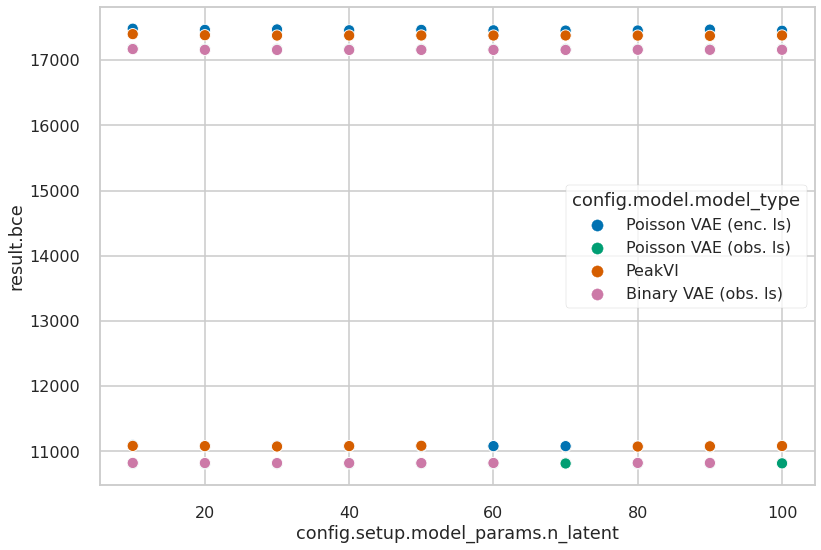

In [198]:
sns.scatterplot(data=results, x="config.setup.model_params.n_latent", y="result.bce", hue="config.model.model_type")

<AxesSubplot:xlabel='Overall', ylabel='result.bce'>

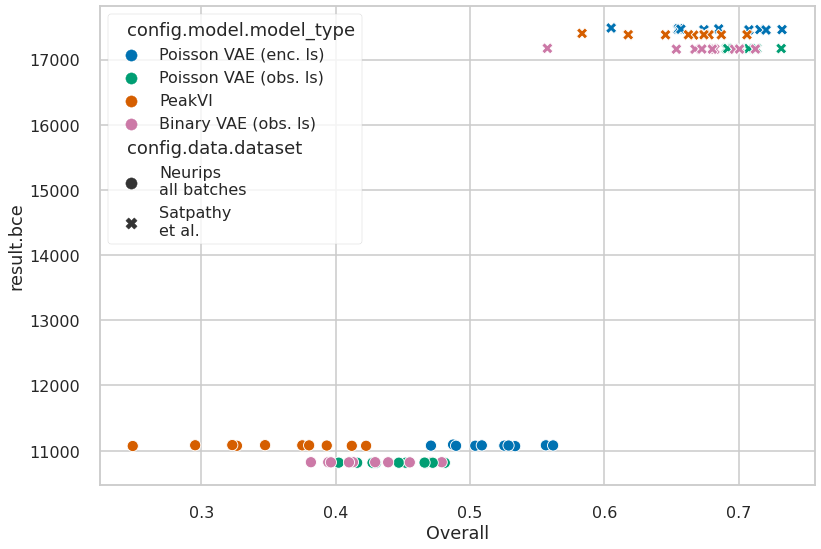

In [199]:
sns.scatterplot(data=results, y="result.bce", x="Overall", hue="config.model.model_type", style='config.data.dataset')

<AxesSubplot:xlabel='Overall', ylabel='result.average_precision'>

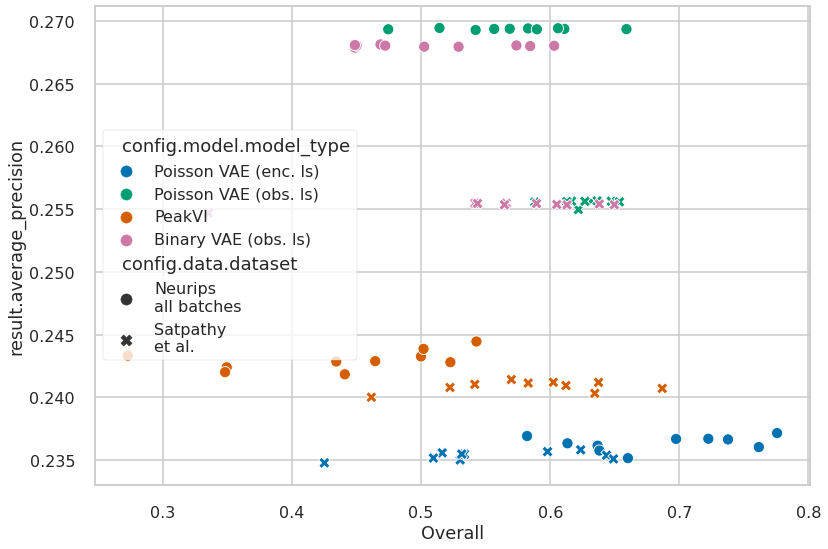

In [201]:
sns.scatterplot(data=results, y="result.average_precision", x="Overall", hue="config.model.model_type", style="config.data.dataset")

# Plot best integration UMAP

In [202]:
from poisson_atac.utils import load_experiment, compute_embedding

In [203]:
from poisson_atac.seml.atac_to_atac.cross_validation.cv_atac_to_atac import get_experiment

In [163]:
scib_table["bce"] = results['result.bce']

In [208]:
best = scib_table[scib_table.n_latent<=100].sort_values("Overall", ascending=False).groupby(["Dataset", "Model"]).first()#.rank(ascending=False)

In [209]:
best

Overall  PCR_batch  \
Dataset              Model                                        
Neurips\nall batches Binary VAE (obs. ls)   0.603086   0.617937   
                     PeakVI                 0.542852   0.321674   
                     Poisson VAE (enc. ls)  0.775731   1.000000   
                     Poisson VAE (obs. ls)  0.659085   0.569938   
Satpathy\net al.     Binary VAE (obs. ls)   0.649690   0.568538   
                     PeakVI                 0.686799   0.000000   
                     Poisson VAE (enc. ls)  0.649019   0.636102   
                     Poisson VAE (obs. ls)  0.653619   0.558600   

                                            ASW_label/batch     iLISI  \
Dataset              Model                                              
Neurips\nall batches Binary VAE (obs. ls)          0.524931  0.318414   
                     PeakVI                        0.858004  0.417046   
                     Poisson VAE (enc. ls)         0.879355  1.000000   
                     Poisson VAE (obs. ls)         0.394302  0.061042   
Satpathy\net al.     Binary VAE (obs. ls)          0.852885  0.543158   
                     PeakVI                        0.737732  0.286466   
                     Poisson VAE (enc. ls)         0.974063  0.649720   
                     Poisson VAE (obs. ls)         0.923394  0.505169   

                                            graph_conn  NMI_cluster/label  \
Dataset              Model                                                  
Neurips\nall batches Binary VAE (obs. ls)     0.662868           0.523989   
                     PeakVI                   0.854316           0.467911   
                     Poisson VAE (enc. ls)    0.832098           0.750433   
                     Poisson VAE (obs. ls)    0.635655           0.586316   
Satpathy\net al.     Binary VAE (obs. ls)     0.789983           0.715046   
                     PeakVI                   1.000000           0.949140   
                     Poisson VAE (enc. ls)    0.564734           0.781948   
                     Poisson VAE (obs. ls)    0.782232           0.739547   

                                            ARI_cluster/label  ASW_label  \
Dataset              Model                                                 
Neurips\nall batches Binary VAE (obs. ls)            0.812125   0.709953   
                     PeakVI                          0.747570   0.108459   
                     Poisson VAE (enc. ls)           1.000000   0.390857   
                     Poisson VAE (obs. ls)           0.733616   0.800984   
Satpathy\net al.     Binary VAE (obs. ls)            0.605172   0.458216   
                     PeakVI                          0.960002   0.783134   
                     Poisson VAE (enc. ls)           0.894040   0.257470   
                     Poisson VAE (obs. ls)           0.785470   0.447516   

                                            isolated_label_F1  \
Dataset              Model                                      
Neurips\nall batches Binary VAE (obs. ls)            0.182908   
                     PeakVI                          0.182836   
                     Poisson VAE (enc. ls)           0.265026   
                     Poisson VAE (obs. ls)           1.000000   
Satpathy\net al.     Binary VAE (obs. ls)            0.449255   
                     PeakVI                          0.779636   
                     Poisson VAE (enc. ls)           0.379917   
                     Poisson VAE (obs. ls)           0.266850   

                                            isolated_label_silhouette  \
Dataset              Model                                              
Neurips\nall batches Binary VAE (obs. ls)                    0.786837   
                     PeakVI                                  0.308283   
                     Poisson VAE (enc. ls)                   0.758173   
                     Poisson VAE (obs. ls)                   0.760505   
Satpathy\net al.     B

In [210]:
rank = best.rank(ascending=False)
rank

Overall  PCR_batch  \
Dataset              Model                                       
Neurips\nall batches Binary VAE (obs. ls)       7.0        3.0   
                     PeakVI                     8.0        7.0   
                     Poisson VAE (enc. ls)      1.0        1.0   
                     Poisson VAE (obs. ls)      3.0        4.0   
Satpathy\net al.     Binary VAE (obs. ls)       5.0        5.0   
                     PeakVI                     2.0        8.0   
                     Poisson VAE (enc. ls)      6.0        2.0   
                     Poisson VAE (obs. ls)      4.0        6.0   

                                            ASW_label/batch  iLISI  \
Dataset              Model                                           
Neurips\nall batches Binary VAE (obs. ls)               7.0    6.0   
                     PeakVI                             4.0    5.0   
                     Poisson VAE (enc. ls)              3.0    1.0   
                     Poisson VAE (obs. ls)              8.0    8.0   
Satpathy\net al.     Binary VAE (obs. ls)               5.0    3.0   
                     PeakVI                             6.0    7.0   
                     Poisson VAE (enc. ls)              1.0    2.0   
                     Poisson VAE (obs. ls)              2.0    4.0   

                                            graph_conn  NMI_cluster/label  \
Dataset              Model                                                  
Neurips\nall batches Binary VAE (obs. ls)          6.0                7.0   
                     PeakVI                        2.0                8.0   
                     Poisson VAE (enc. ls)         3.0                3.0   
                     Poisson VAE (obs. ls)         7.0                6.0   
Satpathy\net al.     Binary VAE (obs. ls)          4.0                5.0   
                     PeakVI                        1.0                1.0   
                     Poisson VAE (enc. ls)         8.0                2.0   
                     Poisson VAE (obs. ls)         5.0                4.0   

                                            ARI_cluster/label  ASW_label  \
Dataset              Model                                                 
Neurips\nall batches Binary VAE (obs. ls)                 4.0        3.0   
                     PeakVI                               6.0        8.0   
                     Poisson VAE (enc. ls)                1.0        6.0   
                     Poisson VAE (obs. ls)                7.0        1.0   
Satpathy\net al.     Binary VAE (obs. ls)                 8.0        4.0   
                     PeakVI                               2.0        2.0   
                     Poisson VAE (enc. ls)                3.0        7.0   
                     Poisson VAE (obs. ls)                5.0        5.0   

                                            isolated_label_F1  \
Dataset              Model                                      
Neurips\nall batches Binary VAE (obs. ls)                 7.0   
                     PeakVI                               8.0   
                     Poisson VAE (enc. ls)                6.0   
                     Poisson VAE (obs. ls)                1.0   
Satpathy\net al.     Binary VAE (obs. ls)                 3.0   
                     PeakVI                               2.0   
                     Poisson VAE (enc. ls)                4.0   
                     Poisson VAE (obs. ls)                5.0   

                                            isolated_label_silhouette  cLISI  \
Dataset              Model                                                     
Neurips\nall batches Binary VAE (obs. ls)                         4.0    7.0   
                     PeakVI                                       8.0    3.0   
                     Poisson VAE (enc. ls)                        6.0    6.0   
                     Poisson VAE (obs. ls)                        5.0    2.0   
Satpathy\net al.   

In [211]:
rank.sum(axis=1)

Dataset               Model                
Neurips\nall batches  Binary VAE (obs. ls)     76.5
                      PeakVI                   79.0
                      Poisson VAE (enc. ls)    46.5
                      Poisson VAE (obs. ls)    58.0
Satpathy\net al.      Binary VAE (obs. ls)     59.0
                      PeakVI                   52.5
                      Poisson VAE (enc. ls)    52.5
                      Poisson VAE (obs. ls)    54.0
dtype: float64

In [39]:
model_hash="3028f5b110abb8e6715f59334b205ef5"#best.loc["Poisson VAEFalse2.0", "model_hash"]

In [40]:
ex, model, config = load_experiment(seml_collection, model_hash, get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/nCount_peaks' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/atac_fragments' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/reads_in_peaks_frac' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/

PEAKVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=70, bias=True)
    (var_encoder): Linear(in_features=341, out_features=70, bias=True)
  )
  (z_decoder): Decoder(
    (px_decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=80, out_features=34

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [131]:
X_emb = model.get_latent_representation(ex.adata)
compute_embedding(ex.adata, X_emb)

In [44]:
l = model.get_library_size_factors()

In [60]:
import torch
import scipy.stats

tensor([0.9998, 0.9999, 0.9998,  ..., 0.9996, 0.9997, 0.9998],
       dtype=torch.float64)

In [77]:
scipy.stats.pearsonr(l, torch.sigmoid(torch.from_numpy(ex.adata.obs.nCount_peaks.values/ex.adata.shape[1])))

(0.7871767727701013, 0.0)

In [76]:
ex.adata.obs

,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch,pseudotime_order_GEX,is_train,size_factor,_scvi_batch,_scvi_labels
TAGTTGTCACCCTCAC-1-s1d1,4031.0,5400,0.746481,0.003473,0.642468,Naive CD20+ B,NaN,s1d1,NaN,True,2105.0,0,0
CTATGGCCATAACGGG-1-s1d1,8636.0,19266,0.448251,0.003126,1.220679,CD14+ Mono,NaN,s1d1,NaN,True,4408.0,0,0
CCGCACACAGGTTAAA-1-s1d1,4674.0,6177,0.756678,0.001284,0.692573,CD8+ T,NaN,s1d1,NaN,True,2477.0,0,0
TCATTTGGTAATGGAA-1-s1d1,2803.0,4019,0.697437,0.000714,0.633838,CD8+ T,NaN,s1d1,NaN,True,1480.0,0,0
ACCACATAGGTGTCCA-1-s1d1,1790.0,2568,0.697040,0.003352,0.727660,CD16+ Mono,NaN,s1d1,NaN,True,930.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTCACTTCCTGCGAA-14-s3d7,1349.0,3065,0.440131,0.000000,0.963134,CD8+ T,NaN,s3d7,NaN,True,754.0,9,0
GCTCTGTTCTGCAAGT-14-s3d7,8312.0,20679,0.401954,0.000241,0.756219,G/M prog,NaN,s3d7,NaN,True,4428.0,9,0
GCTGAGGAGTGAGCGG-14-s3d7,2674.0,6903,0.387368,0.000000,0.941300,Erythroblast,0.828536,s3d7,0.791014,True,1466.0,9,0
TACTGAGGTTCGCTCA-14-s3d7,3920.0,8229,0.476364,0.000510,0.788606,CD14+ Mono,NaN,s3d7,NaN,True,2109.0,9,0


<AxesSubplot:>

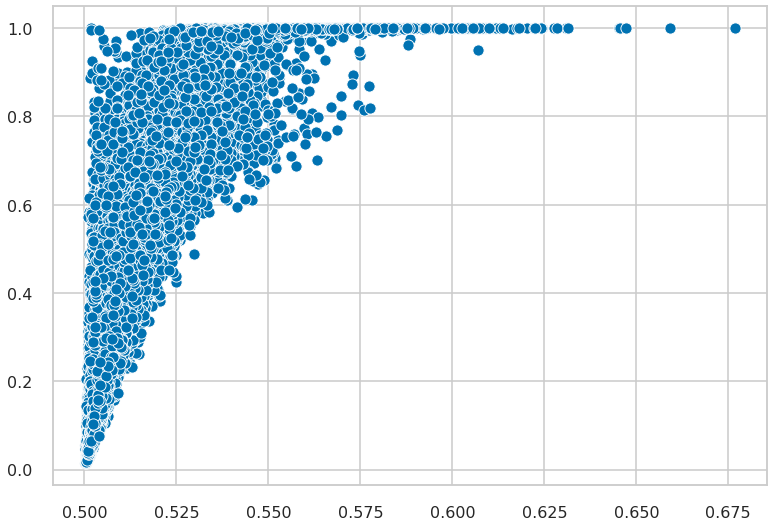

In [73]:
sns.scatterplot(y=l, x=torch.sigmoid(torch.from_numpy(ex.adata.obs.nCount_peaks.values/ex.adata.shape[1])))

In [46]:
ex.adata.obs

,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch,pseudotime_order_GEX,is_train,size_factor,_scvi_batch,_scvi_labels
TAGTTGTCACCCTCAC-1-s1d1,4031.0,5400,0.746481,0.003473,0.642468,Naive CD20+ B,NaN,s1d1,NaN,True,2105.0,0,0
CTATGGCCATAACGGG-1-s1d1,8636.0,19266,0.448251,0.003126,1.220679,CD14+ Mono,NaN,s1d1,NaN,True,4408.0,0,0
CCGCACACAGGTTAAA-1-s1d1,4674.0,6177,0.756678,0.001284,0.692573,CD8+ T,NaN,s1d1,NaN,True,2477.0,0,0
TCATTTGGTAATGGAA-1-s1d1,2803.0,4019,0.697437,0.000714,0.633838,CD8+ T,NaN,s1d1,NaN,True,1480.0,0,0
ACCACATAGGTGTCCA-1-s1d1,1790.0,2568,0.697040,0.003352,0.727660,CD16+ Mono,NaN,s1d1,NaN,True,930.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTCACTTCCTGCGAA-14-s3d7,1349.0,3065,0.440131,0.000000,0.963134,CD8+ T,NaN,s3d7,NaN,True,754.0,9,0
GCTCTGTTCTGCAAGT-14-s3d7,8312.0,20679,0.401954,0.000241,0.756219,G/M prog,NaN,s3d7,NaN,True,4428.0,9,0
GCTGAGGAGTGAGCGG-14-s3d7,2674.0,6903,0.387368,0.000000,0.941300,Erythroblast,0.828536,s3d7,0.791014,True,1466.0,9,0
TACTGAGGTTCGCTCA-14-s3d7,3920.0,8229,0.476364,0.000510,0.788606,CD14+ Mono,NaN,s3d7,NaN,True,2109.0,9,0


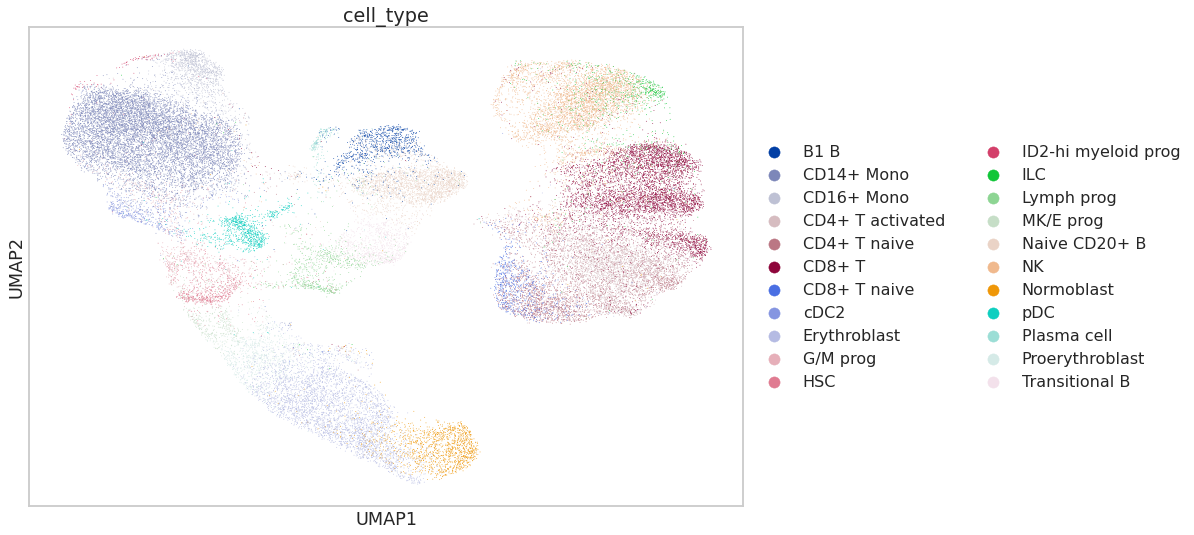

In [132]:
sc.pl.umap(ex.adata, color="cell_type")

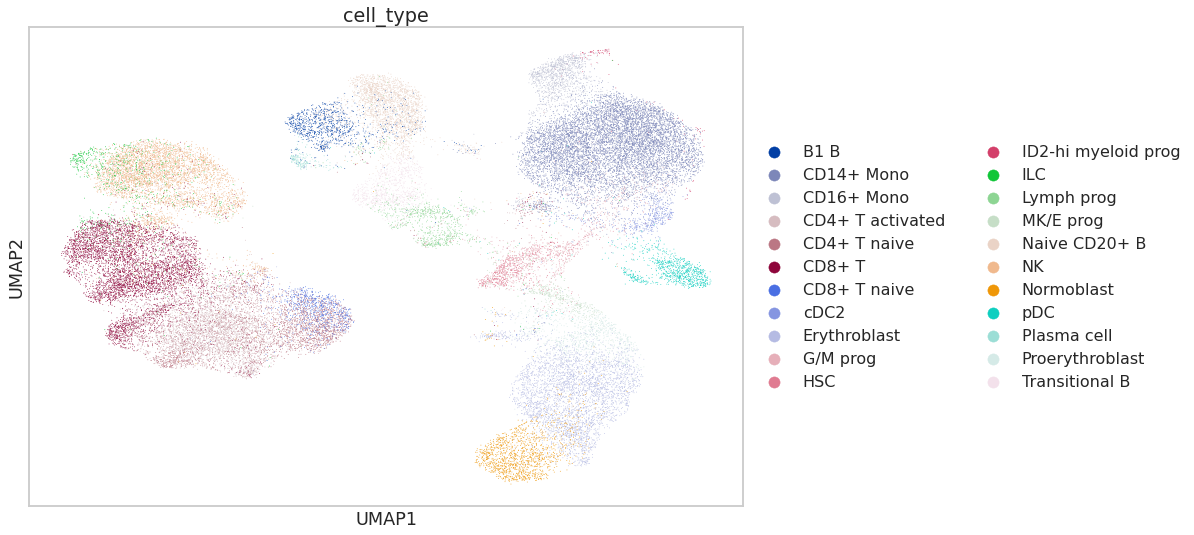

In [125]:
sc.pl.umap(ex.adata, color="cell_type")

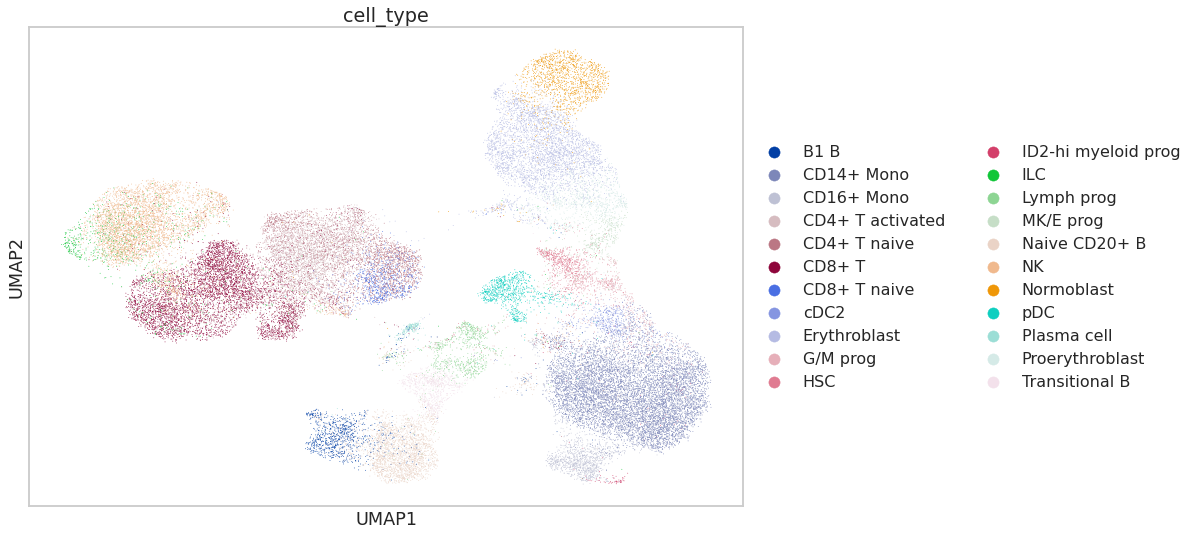

In [50]:
sc.pl.umap(ex.adata, color="cell_type")

In [16]:
model_hash=best.loc["Poisson VAETruenan", "model_hash"]

In [18]:
ex, model, config = load_experiment(seml_collection, model_hash, get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/nCount_peaks' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/atac_fragments' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/reads_in_peaks_frac' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/

PoissonVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=100, bias=True)
    (var_encoder): Linear(in_features=341, out_features=100, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_featu

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
X_emb = model.get_latent_representation(ex.adata)
compute_embedding(ex.adata, X_emb)

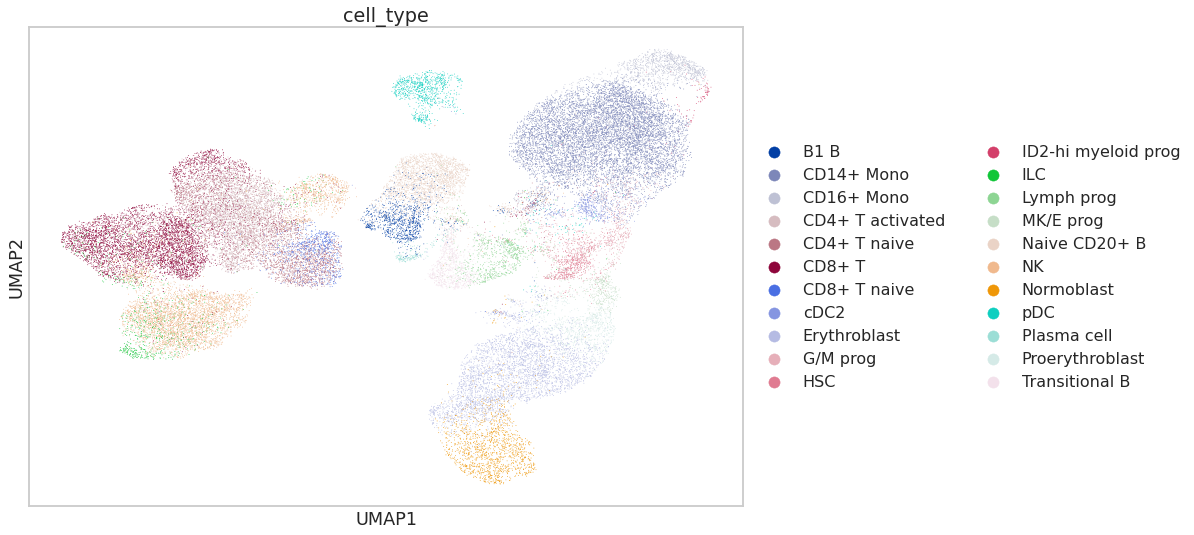

In [20]:
sc.pl.umap(ex.adata, color="cell_type")